https://www.datacamp.com/tutorial/nlp-with-pytorch-a-comprehensive-guide

In [3]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
from nltk.corpus import stopwords
import nltk
import re
from collections import Counter
from torch.utils.data import TensorDataset
import torch
import statistics

from collections import Counter

In [4]:
os.chdir('E:\Python code\IBM 文本分类数据')

In [5]:
file_name = 'IMDB Dataset.csv'
df = pd.read_csv(file_name)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
# 计算字符串列中每一行文本的长度
text_lengths = df['review'].str.len()
#print(text_lengths)
# 查看文本长度的分布
length_distribution = text_lengths.value_counts().sort_index()

#查看中位数
madian_value = statistics.median(text_lengths)

print(f"中位数: {madian_value}")

#查看众数
counter = Counter(text_lengths)

# 找到出现次数最多的值
max_count = max(counter.values())

# 获取所有众数（出现次数等于max_count的元素）
modes = [key for key, count in counter.items() if count == max_count]

print(f"众数: {modes}")

中位数: 970.0
众数: [658]


探索性数据分析

train data shape: (37500,)
test data shape: (12500,)


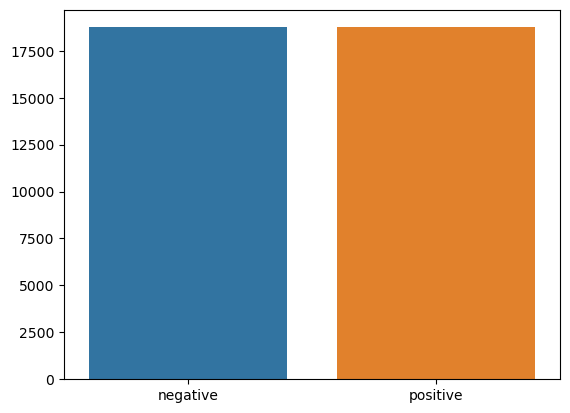

In [7]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'train data shape: {x_train.shape}')
print(f'test data shape: {x_test.shape}')


dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

# 文本特征工程

In [9]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    return s


def tokenize(x_train,y_train,x_val,y_val):
    word_list = []


    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
 
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
   
    # tokenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
        
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])
           
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val]


    #设置数据的最大长度
    #final_list_train = preprocess_seq_len(final_list_train,max_length)
    
    #final_list_test = preprocess_seq_len(final_list_test,max_length)
        

    
    #return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict
    return final_list_train, encoded_train,final_list_test, encoded_test,onehot_dict


x_train,y_train,x_test,y_test,vocab = tokenize(x_train,y_train,x_test,y_test)

<Axes: >

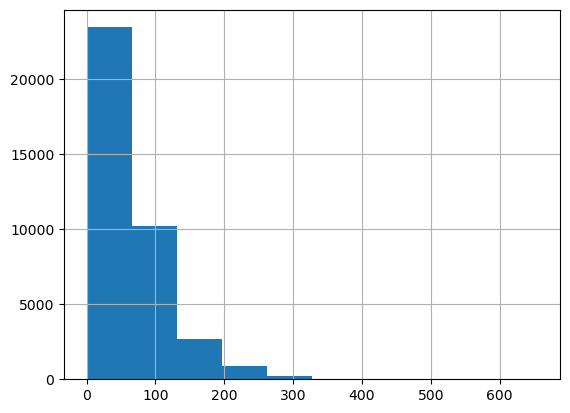

In [10]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()

In [15]:
max_length = 50

def preprocess_seq_len(data,max_length):
    
    return_data  = []
    for seqs in data:
        #print(seqs)
        if len(seqs)>=max_length:
            seqs = seqs[0:max_length]
        else:
            # 填充所有子列表到这个长度
            seqs = seqs + [0] * (max_length - len(seqs))
        #print(seqs)
        return_data.append(seqs)
        
    return return_data

In [24]:
x_train_1 = preprocess_seq_len(x_train,max_length)
x_train_1 = np.array(x_train_1)

In [25]:
x_test_1 = preprocess_seq_len(x_test,max_length)
x_test_1 = np.array(x_test_1)

In [35]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features


x_train_pad = padding_(x_train_1,50)
x_test_pad = padding_(x_test_1,50)

In [36]:
x_train_pad[1]

array([346, 712, 119, 734, 456, 491, 569, 248, 888, 131, 318,   3, 315,
        39,   3,  29,  57, 329, 714, 456,  24,   3,  91, 508,  66, 155,
        72,  93, 149, 105, 634,  58, 318,   3,  63,  23, 119, 656, 491,
       141, 714, 338, 182, 268, 124,   8, 118, 196, 119, 354])

In [37]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))


# dataloaders
batch_size = 50


# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)


# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)


print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample output: \n', sample_y)

TypeError: expected np.ndarray (got list)

In [ ]:
x_train_1 = np.array(x_train[0])

for i in x_train[1::]:
    #test.append(np.array(i))
    new_element = np.array(i)
    x_train_1 = np.concatenate((x_train_1, new_element))

#x_train = x_train_1.copy()

In [10]:
# 假设我们有两个列表
list1 = [1, 2, 3]
list2 = [4, 5, 6]
list3 = [7, 8, 9]

# 使用 extend 方法组合列表
combined_list = list1.copy()  # 创建 list1 的副本
combined_list.extend(list2)
combined_list.extend(list3)

print(combined_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9]


In [17]:
y_train_1 = np.array(y_train[0])

In [18]:
y_train_2 = np.array(y_train[1])

In [21]:
type(np.array(y_train_1,y_train_2))

TypeError: Cannot construct a dtype from an array

In [9]:
for i in y_train[1::]:
    #test.append(np.array(i))
    new_element = np.array(i)

In [7]:
y_train_1 = np.array(y_train[0])

for i in y_train[1::]:
    #test.append(np.array(i))
    new_element = np.array(i)
    y_train_1 = np.concatenate((y_train_1, new_element))

y_train = y_train_1.copy()

ValueError: zero-dimensional arrays cannot be concatenated

In [13]:
y_train_1 = np.array(y_train[0])

In [15]:
for i in y_train[1::]:
    #test.append(np.array(i))
    new_element = np.array(i)
    #print(new_element)
    print(new_element)
    y_train_1 = np.concatenate((y_train_1, new_element))

0


ValueError: zero-dimensional arrays cannot be concatenated

In [70]:
type(x_train)

list

In [74]:
len(x_train[0])

276

In [ ]:
x_train_1 = np.array(x_train[0])

for i in x_train[1::]:
    #test.append(np.array(i))
    new_element = np.array(i)
    x_train_1 = np.concatenate((x_train_1, new_element))

In [81]:
type(test)

numpy.ndarray

In [76]:
np.array(x_train[0:100])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (100,) + inhomogeneous part.

<Axes: >

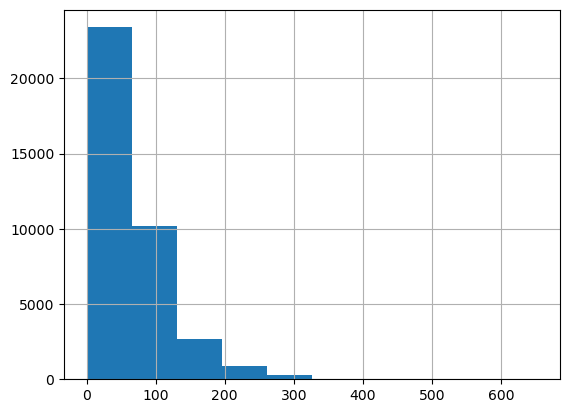

In [62]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()

4. 准备模型的数据
4. Zhǔnbèi móxíng de shùjù

In [63]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features


x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

In [68]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))


TypeError: expected np.ndarray (got list)

In [27]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    return s


def tokenize(x_train,y_train,x_val,y_val):
    word_list = []


    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
 
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
   
    # tokenize
    final_list_train,final_list_test = [],[]
    
    for sent in x_train:
        token_list = [onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                      if preprocess_string(word) in onehot_dict.keys() and preprocess_string(word)]
        if token_list:  # 只在token_list不为空时追加
            final_list_train.append(token_list)
    
    for sent in x_val:
        token_list = [onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                      if preprocess_string(word) in onehot_dict.keys() and preprocess_string(word)]
        if token_list:  # 只在token_list不为空时追加
            final_list_test.append(token_list)

           
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val]
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


x_train,y_train,x_test,y_test,vocab = tokenize(x_train,y_train,x_test,y_test)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (37499,) + inhomogeneous part.